In [1]:
from datetime import datetime
import os
from time_utils.gpst import dt2gpst, gpst2dt, gpst_week_number, gpst_week_day

import zipfile
import tarfile
import gzip
import shutil

from ftplib import FTP
from os.path import basename, dirname, join, exists
from os import makedirs

import numpy

import matplotlib.pyplot as plt

In [2]:
import zipfile
import tarfile

import gzip
import shutil

rarfile = None
try:
    import rarfile
except ImportError:
    msg = '`rarfile` package not found.  ".rar" file decompression will not be available'
    print(msg)
    #raise ImportError(msg)

from os.path import dirname, join, basename
import subprocess

`rarfile` package not found.  ".rar" file decompression will not be available


In [3]:
def format_filepath(filepath_expr, dt=None, params={}):
    '''
    ------------------------------------------------------------------------
    `filepath_expr` -- a formattable string that defines the full filepath.
        Intended to mirror filepath format on website / FTP site (should be
        mirrored by folder structure of downloaded files).  See below about
        placeholders.
        
    Placeholders:
        Use the Python format syntax for adding placeholders to the path or
        file expressions.  E.g. `/path/to/data/{type}/`.  These will be
        replaced via `.format` with `params` as the argument.
    
    Reserved Placeholders:
        For date/time-related expressions in the path or filename
        expressions, use the placeholders used on IGS products page (e.g.
        wwww, yyyy, ddd, etc).  When passing in a datetime into
        `format_filepath(<filepath>, dt=datetime)`, this function computes
        all the necessary placeholders.

    Example:
        IGS MGEX path expression: /pub/gps/products/mgex/{wwww}/
        IGS MGEX sp3 file expression: com{wwww}{d}.sp3.Z
        New MGEX SP3 file expression: COD0MGXFIN_{yyyy}{ddd}0000_01D_05M_ORB.SP3.gz
    
    Note on `path_expression` leading '/':
        Strips leading forward slash in path expression to avoid issues
        with `join`.  Path expression is always relative to some host URL
        or local data directory.

    Note for SP3:
        For MGEX (basepath = '/pub/igs/products/mgex'), we can use the `com` files which include all available GNSS data
        When using basepath pub/products/ ...:
            for GPS use 'igs';
            for GLONASS use 'igl' (after GPS week 1300) or 'igx' (before GPS week 1300)
    '''
    if dt is not None:
        gpst = dt2gpst(dt)
        week_no = gpst_week_number(gpst)
        week_day = gpst_week_day(gpst)
        yyyy = '{0:04}'.format(dt.year)                # year
        yy = '{0:02}'.format(dt.year % 100)            # 2-digit year
        mm = '{0:02}'.format(dt.month)                 # month
        wwww = '{0:04}'.format(week_no)       # gps week no.
        ddd = '{0:03}'.format(dt.timetuple().tm_yday)  # day of year
        d = '{0:01}'.format(int(week_day))    # day of week
        date_params = {'yyyy': yyyy, 'yy': yy, 'mm': mm, 'wwww': wwww, 'ddd': ddd, 'd': d}
        params.update(date_params)
    return filepath_expr.format(**params)

In [4]:
from ftplib import FTP
from os.path import basename, dirname, join, exists
from os import makedirs

def ftp_download(ftp_host, url_filepath, output_filepath):
    '''Given URL to data on FTP site and a local output location, uses Python
    FTP library's `retrbinary` function to download file.
    '''
    path = dirname(url_filepath)
    filename = basename(url_filepath)
    ftp = FTP(ftp_host)
    ftp.login()
    ftp.cwd(path)
    with open(output_filepath, 'wb') as f:
        ftp.retrbinary('RETR ' + filename, f.write)
    ftp.quit()
    return True

In [5]:
import zipfile
import tarfile

import gzip
import shutil

rarfile = None
try:
    import rarfile
except ImportError:
    msg = '`rarfile` package not found.  ".rar" file decompression will not be available'
    print(msg)
    #raise ImportError(msg)

from os.path import dirname, join, basename
import subprocess


def fix_bad_zip_file(zipFile):
    '''See here:  https://stackoverflow.com/questions/3083235/unzipping-file-results-in-badzipfile-file-is-not-a-zip-file'''
    with open(zipFile, 'rb') as f:
        data = f.read()
        pos = data.find(b'\x50\x4b\x05\x06') # End of central directory signatur
        if (pos > 0):
            self._log("Trancating file at location " + str(pos + 22)+ ".")
            f.seek(pos + 22)   # size of 'ZIP end of central directory record'
            f.truncate()  
            f.close()  
        else:
            # raise error, file is truncated
            raise Exception('Bad zip file: file is truncated')


def decompress(filepath, output_filepath):
    '''
    ----------------------------------------------------------------------------
    Given the path to file `filepath`, determines whether one of the modules
    `zipfile`, `tarfile`, `gzip`, or (if available) `rarfile` is capable of 
    reading and decompressing the file.  Then, decompresses file and writes to
    `output_filepath`.  Returns False if decompression fails.

    Notes:  `gzip` module will only be used if filepath ends in '.gz'
    '''
    path = dirname(filepath)
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath, 'r') as f:
            res = f.extractall(path)
        return join(path, basename(output_filepath)) == output_filepath
    if tarfile.is_tarfile(filepath):
        with tarfile.TarFile(filepath, 'r') as f:
            f.extractall(path)
        return join(path, basename(output_filepath)) == output_filepath
    if rarfile is not None:
        if rarfile.is_rarfile(filepath):
            with rarfile.RarFile(filepath, 'r') as f:
                f.extractall(path)
            return join(path, basename(output_filepath)) == output_filepath
    if filepath[-3:] == '.gz':
        with gzip.open(filepath, 'rb') as f_in:
            with open(output_filepath, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        return output_filepath
    if filepath[-2:] in ['.Z', '.z']:
        # Unix compression; use uncompress
        res = subprocess.call('uncompress -f ' + filepath, shell=True)
        if res == 0:
            return filepath[:-2] == output_filepath
    # check for bad zip file
    if filepath[-4:] in ['.zip']:
        res = subprocess.call('unzip ' + filepath, shell=True)
        if res == 0:
            return filepath[:-4] == output_filepath
    return False

`rarfile` package not found.  ".rar" file decompression will not be available


In [16]:
ftp_host = 'cddis.gsfc.nasa.gov'
filepath_template = \
    'pub/gps/data/daily/{yyyy}/{ddd}/{yy}o/yell{ddd}0.{yy}o.Z'
url_filepath = format_filepath(filepath_template, datetime(2018, 9, 3))

In [17]:
filepath = os.path.join('/Users/liuzijun 1/Projects/gnss-research/data/rinex/', url_filepath)
if not os.path.exists(os.path.dirname(filepath)):
    os.makedirs(os.path.dirname(filepath))
if not os.path.exists(filepath):
    success = ftp_download(ftp_host, url_filepath, filepath)
subprocess.call('uncompress -f ' + filepath.replace(' ', '\ '), shell=True)
filepath = filepath[:-2]

In [18]:
from rinex2 import parse_RINEX2_obs_file

In [19]:
header, observations = parse_RINEX2_obs_file(filepath)

In [20]:
sat = observations['satellites']['G05']

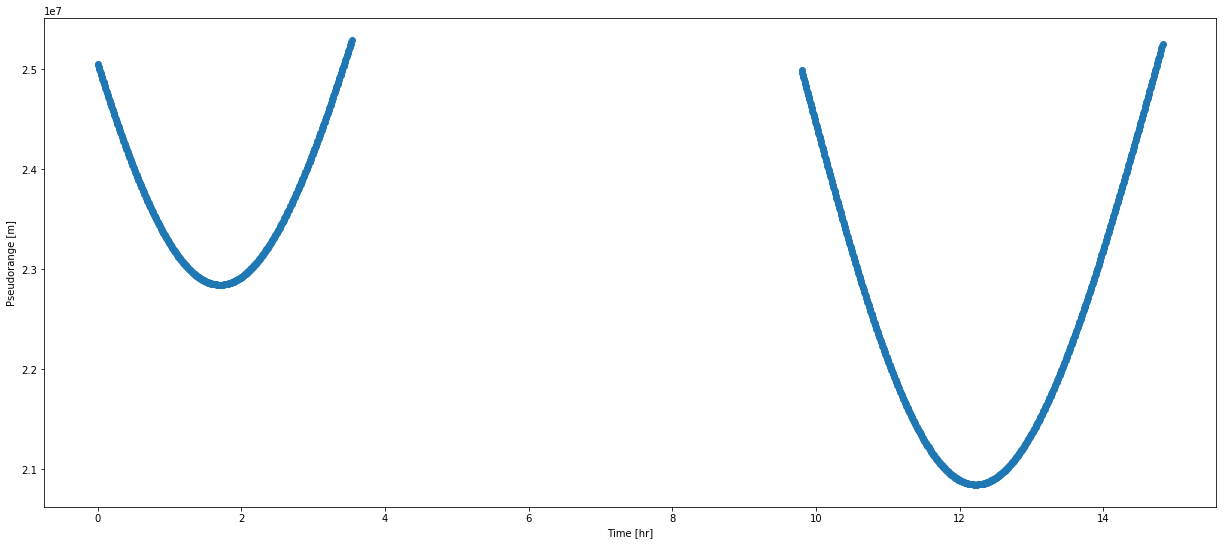

In [21]:
fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(111)
time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time / 3600, sat['L1']['pseudorange'])
ax.set_ylabel('Pseudorange [m]')
ax.set_xlabel('Time [hr]')
plt.show()

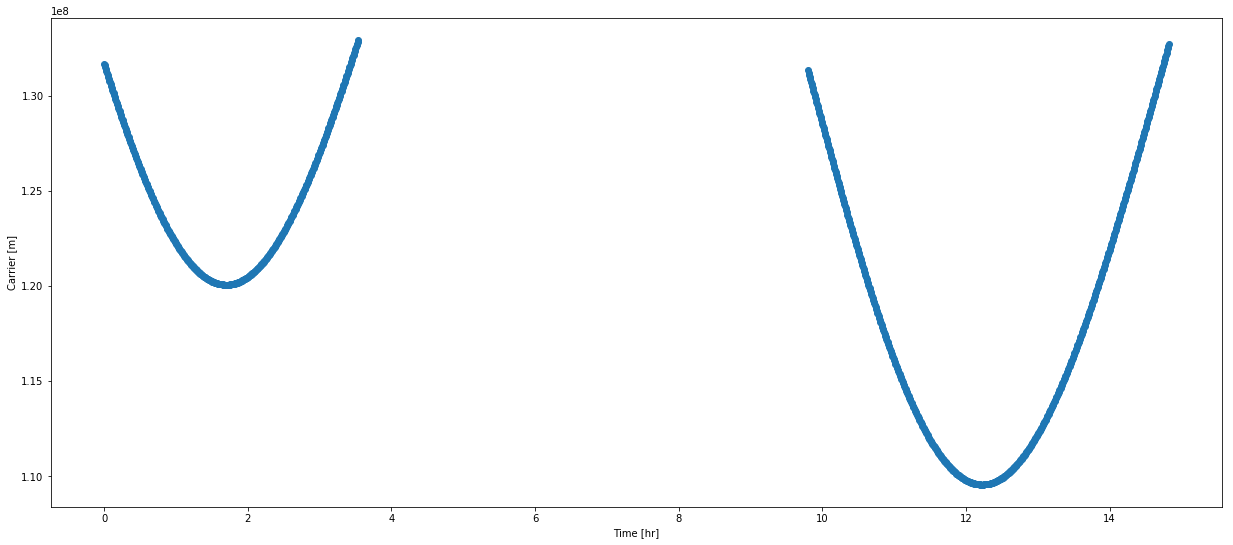

In [22]:
fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(111)
time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time / 3600, sat['L1']['carrier'])
ax.set_ylabel('Carrier [m]')
ax.set_xlabel('Time [hr]')
plt.show()

$\textbf{Notice}$:
This is the Pseudorange and Carrier vs time plot I draw here. 

At 2AM and 11AM, the satellites closest to us. 

In [23]:
from scipy.constants import c

In [24]:
kappa_u = 40.308e16
fL1 = 1.57542e9
fL2 = 1.2276e9
P1 = sat['L1']['pseudorange']
P2 = sat['L2']['pseudorange']
TEC = (P1 - P2) / (kappa_u * (1 / fL1**2 - 1 / fL2**2))

L1 = sat['L1']['carrier'] * c / fL1
L2 = sat['L2']['carrier'] * c / fL2
TEC_rel = -(L1 - L2) / (kappa_u * (1 / fL1**2 - 1 / fL2**2))

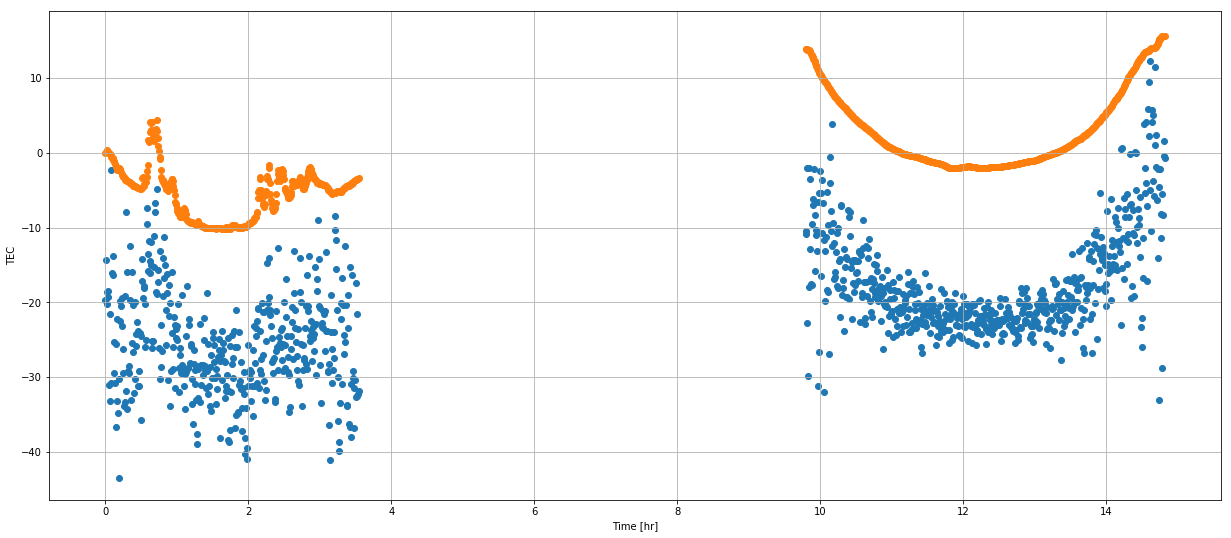

In [25]:
fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(111)

time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time / 3600, TEC)
ax.scatter(time / 3600, TEC_rel)
ax.set_ylabel('TEC')
ax.set_xlabel('Time [hr]')
ax.grid()
plt.show()

In [29]:
TEC_diff = numpy.diff(TEC_rel)
threshold = 0.4
indices = abs(TEC_diff) > threshold

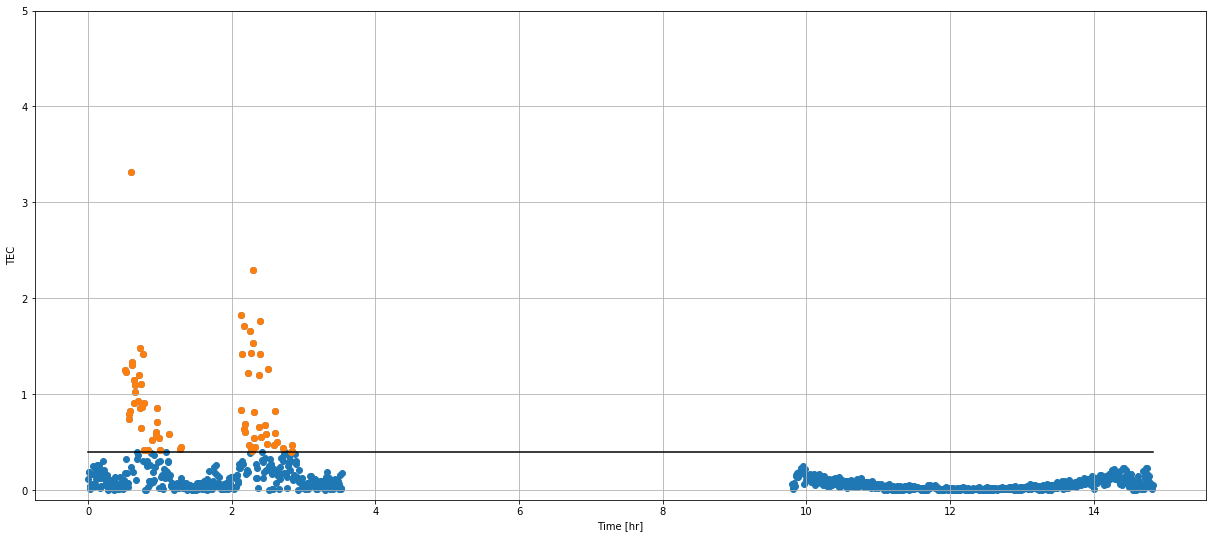

In [30]:
fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(111)

time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time[:-1] / 3600, abs(TEC_diff))
ax.scatter((time[:-1])[indices] / 3600, abs(TEC_diff)[indices])
ax.plot(time[[0, -1]] / 3600, (threshold,) * 2, color='k')
ax.set_ylim(-.1, 5)
ax.set_ylabel('TEC')
ax.set_xlabel('Time [hr]')
ax.grid()
plt.show()

threshold = 0.4

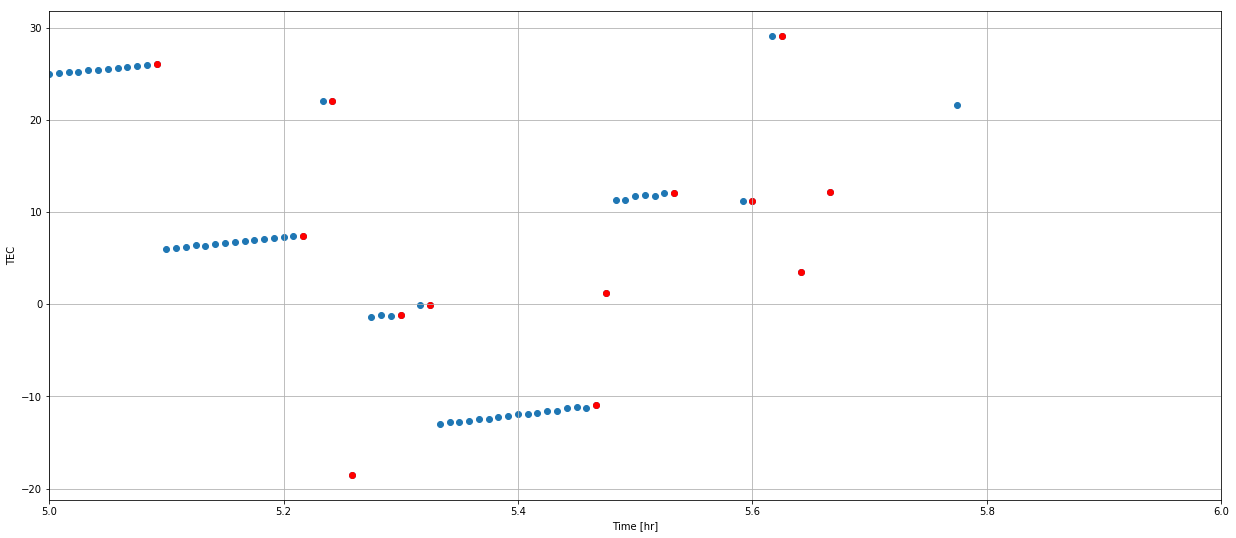

In [48]:
fig = plt.figure(figsize=(21, 9))
ax = fig.add_subplot(111)

time = observations['time'][sat['index']]
time -= time[0]
# ax.scatter(time / 3600, TEC)
ax.scatter(time / 3600, TEC_rel)
ax.scatter((time[:-1])[indices] / 3600, (TEC_rel[:-1])[indices], color='r')
ax.set_ylabel('TEC')
ax.set_xlabel('Time [hr]')
ax.grid()
ax.set_xlim(5, 6)
plt.show()

In [50]:
numpy.sum(indices)

13